# v8 Data Preparation: E5 Embedding + K-Means Clustering

이 노트북에서는 공공 데이터셋을 사용하여 E5 multilingual 임베딩과 K-means 클러스터링으로 동의어 셋을 생성합니다.

## 목표
1. 공공 데이터셋 로드 (HuggingFace datasets)
2. E5 multilingual 임베딩 생성
3. K-means 클러스터링으로 동의어 그룹 생성
4. PCA/UMAP 시각화
5. 학습용 데이터셋 저장

## 1. Setup

In [28]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [29]:
import json
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Try to use Korean font
try:
    plt.rcParams['font.family'] = 'NanumGothic'
except:
    pass

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True


## 2. Load Public Dataset

HuggingFace에서 공공 한국어-영어 데이터셋을 로드합니다.

In [30]:
# Option 1: OPUS-100 Korean-English parallel corpus
# This is a public multilingual dataset
print("Loading OPUS-100 Korean-English dataset...")

try:
    dataset = load_dataset("opus100", "en-ko", split="train", trust_remote_code=True)
    print(f"Loaded {len(dataset)} parallel sentences")
except Exception as e:
    print(f"Error loading OPUS-100: {e}")
    print("Trying alternative dataset...")
    # Alternative: Use Helsinki-NLP OPUS dataset
    dataset = load_dataset("Helsinki-NLP/opus-100", "en-ko", split="train")
    print(f"Loaded {len(dataset)} parallel sentences")

Loading OPUS-100 Korean-English dataset...
Loaded 1000000 parallel sentences


In [31]:
# Preview dataset
print("Dataset columns:", dataset.column_names)
print("\nSample entries:")
for i in range(3):
    sample = dataset[i]
    print(f"\n[{i}]")
    print(f"  EN: {sample['translation']['en'][:100]}...")
    print(f"  KO: {sample['translation']['ko'][:100]}...")

Dataset columns: ['translation']

Sample entries:

[0]
  EN: They're shaped like a bus....
  KO: 할머니처럼 만들었지만.. ? 엉망이지만.....

[1]
  EN: I ain't fishing' 'em out....
  KO: 그거 꺼내려다가는...

[2]
  EN: You are torturing god's creatures in an age where we have the technology that no longer requires us ...
  KO: 선생님은 이 기술력이 있는 시대에 그러지 않아도 되는데도 신의 피조물을 괴롭히고 있다고요...


In [32]:
# Extract and clean text pairs
def extract_terms(dataset, max_samples=50000):
    """
    Extract short terms/phrases from parallel corpus.
    Focus on shorter texts that are more likely to be terms.
    """
    terms = []
    
    for i, sample in enumerate(tqdm(dataset, desc="Extracting terms")):
        if i >= max_samples:
            break
            
        en_text = sample['translation']['en'].strip()
        ko_text = sample['translation']['ko'].strip()
        
        # Filter: short texts (more likely to be terms/phrases)
        if 2 <= len(ko_text) <= 30 and 2 <= len(en_text) <= 50:
            # Skip if too many special characters
            if ko_text.count(' ') <= 3 and en_text.count(' ') <= 5:
                terms.append({
                    'ko': ko_text,
                    'en': en_text,
                })
    
    return terms

# Extract terms
raw_terms = extract_terms(dataset, max_samples=100000)
print(f"\nExtracted {len(raw_terms)} term pairs")

Extracting terms:   0%|          | 0/1000000 [00:00<?, ?it/s]


Extracted 47441 term pairs


In [33]:
# Preview extracted terms
print("Sample extracted terms:")
for i in range(min(10, len(raw_terms))):
    print(f"  {raw_terms[i]['ko']} → {raw_terms[i]['en']}")

Sample extracted terms:
  할머니처럼 만들었지만.. ? 엉망이지만.. → They're shaped like a bus.
  그거 꺼내려다가는 → I ain't fishing' 'em out.
  아무도 없음. 알았다 오바. → Roger that.
  그는 어디있나? → Where is he now?
  Stop. → Stop.
  물건들이 부서졌어요 → Things are break.
  그렇지? → All right?
  캥거루. → Kangaroo.
  팬더가 말이야 → A panda.
  전혀. → - No clue.


## 3. E5 Multilingual Embedding

In [34]:
# Load E5 multilingual model
E5_MODEL_NAME = "intfloat/multilingual-e5-large"

print(f"Loading {E5_MODEL_NAME}...")
e5_tokenizer = AutoTokenizer.from_pretrained(E5_MODEL_NAME)
e5_model = AutoModel.from_pretrained(E5_MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
e5_model = e5_model.to(device)
e5_model.eval()

print(f"Model loaded on {device}")

Loading intfloat/multilingual-e5-large...
Model loaded on cuda


In [35]:
def get_e5_embeddings(texts: list, batch_size: int = 32, prefix: str = "query: ") -> np.ndarray:
    """
    Generate E5 embeddings for a list of texts.
    E5 models require a prefix for queries.
    """
    all_embeddings = []
    
    # Add prefix
    texts_with_prefix = [prefix + t for t in texts]
    
    for i in tqdm(range(0, len(texts_with_prefix), batch_size), desc="Generating embeddings"):
        batch_texts = texts_with_prefix[i:i + batch_size]
        
        # Tokenize
        inputs = e5_tokenizer(
            batch_texts,
            max_length=128,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(device)
        
        # Generate embeddings
        with torch.no_grad():
            outputs = e5_model(**inputs)
            # Use mean pooling
            embeddings = outputs.last_hidden_state.mean(dim=1)
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        all_embeddings.append(embeddings.cpu().numpy())
    
    return np.vstack(all_embeddings)

In [36]:
# Generate embeddings for Korean and English terms
ko_texts = [t['ko'] for t in raw_terms]
en_texts = [t['en'] for t in raw_terms]

print(f"Generating embeddings for {len(ko_texts)} Korean terms...")
ko_embeddings = get_e5_embeddings(ko_texts, batch_size=64)

print(f"\nGenerating embeddings for {len(en_texts)} English terms...")
en_embeddings = get_e5_embeddings(en_texts, batch_size=64)

print(f"\nKorean embeddings shape: {ko_embeddings.shape}")
print(f"English embeddings shape: {en_embeddings.shape}")

Generating embeddings for 47441 Korean terms...


Generating embeddings:   0%|          | 0/742 [00:00<?, ?it/s]


Generating embeddings for 47441 English terms...


Generating embeddings:   0%|          | 0/742 [00:00<?, ?it/s]


Korean embeddings shape: (47441, 1024)
English embeddings shape: (47441, 1024)


In [37]:
# Combined embeddings (average of Korean and English)
# This helps create cross-lingual clusters
combined_embeddings = (ko_embeddings + en_embeddings) / 2
combined_embeddings = combined_embeddings / np.linalg.norm(combined_embeddings, axis=1, keepdims=True)

print(f"Combined embeddings shape: {combined_embeddings.shape}")

Combined embeddings shape: (47441, 1024)


## 4. K-Means Clustering for Synonym Discovery

In [38]:
# Determine optimal number of clusters
# Rule of thumb: sqrt(n/2) for large datasets
n_samples = len(combined_embeddings)
n_clusters = min(int(np.sqrt(n_samples / 2)), 500)  # Cap at 500 clusters

print(f"Number of samples: {n_samples}")
print(f"Number of clusters: {n_clusters}")

Number of samples: 47441
Number of clusters: 154


In [39]:
# Apply K-Means clustering
print(f"Running K-Means clustering with {n_clusters} clusters...")

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=1024,
    n_init=3,
    max_iter=100,
)

cluster_labels = kmeans.fit_predict(combined_embeddings)

print(f"Clustering complete!")
print(f"Cluster label range: {cluster_labels.min()} - {cluster_labels.max()}")

Running K-Means clustering with 154 clusters...
Clustering complete!
Cluster label range: 0 - 153


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

Cluster size statistics:
  Min size: 2
  Max size: 973
  Mean size: 308.1
  Median size: 282.0


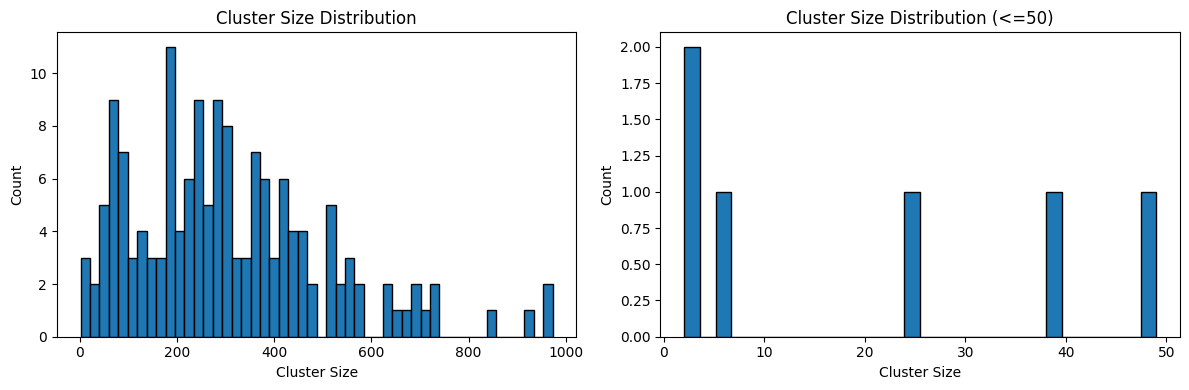

In [40]:
# Analyze cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()

print("Cluster size statistics:")
print(f"  Min size: {cluster_sizes.min()}")
print(f"  Max size: {cluster_sizes.max()}")
print(f"  Mean size: {cluster_sizes.mean():.1f}")
print(f"  Median size: {cluster_sizes.median():.1f}")

# Plot cluster size distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(cluster_sizes, bins=50, edgecolor='black')
plt.xlabel('Cluster Size')
plt.ylabel('Count')
plt.title('Cluster Size Distribution')

plt.subplot(1, 2, 2)
plt.hist(cluster_sizes[cluster_sizes <= 50], bins=30, edgecolor='black')
plt.xlabel('Cluster Size')
plt.ylabel('Count')
plt.title('Cluster Size Distribution (<=50)')

plt.tight_layout()
plt.show()

In [41]:
# Create synonym groups from clusters
def create_synonym_groups(terms: list, cluster_labels: np.ndarray, min_size: int = 2, max_size: int = 20):
    """
    Create synonym groups from clustering results.
    """
    groups = {}
    
    for idx, label in enumerate(cluster_labels):
        if label not in groups:
            groups[label] = []
        groups[label].append(terms[idx])
    
    # Filter by size
    filtered_groups = {
        k: v for k, v in groups.items() 
        if min_size <= len(v) <= max_size
    }
    
    return filtered_groups

synonym_groups = create_synonym_groups(raw_terms, cluster_labels, min_size=2, max_size=15)
print(f"Created {len(synonym_groups)} synonym groups")

Created 3 synonym groups


In [42]:
# Preview synonym groups
print("Sample synonym groups:")
print("=" * 70)

sample_keys = list(synonym_groups.keys())[:10]
for key in sample_keys:
    group = synonym_groups[key]
    print(f"\nCluster {key} ({len(group)} terms):")
    for term in group[:5]:
        print(f"  {term['ko']} → {term['en']}")
    if len(group) > 5:
        print(f"  ... and {len(group) - 5} more")

Sample synonym groups:

Cluster 132 (6 terms):
  무슨 소리야? → What the hell is that?
  무슨 소리야? → What? What does that mean?
  무슨 소리야? → What does that mean?
  이게 뭔 소리래? → What's that knockin'?
  무슨 소리죠? → What was that?
  ... and 1 more

Cluster 28 (2 terms):
  - 조종사 없어요? → - Woah, no pilot?
  - 조카가 없어요? → -No niece?

Cluster 144 (2 terms):
  좋아, 엄마를 찾으러 가자. → Okay, let's go find Mom.
  엄마야 가봐 엄마한테 → Go to your mommy.


## 5. Embedding Visualization (PCA & UMAP)

In [43]:
# Sample for visualization (use subset for speed)
n_viz_samples = min(5000, len(combined_embeddings))
viz_indices = np.random.choice(len(combined_embeddings), n_viz_samples, replace=False)

viz_embeddings = combined_embeddings[viz_indices]
viz_labels = cluster_labels[viz_indices]
viz_ko_texts = [ko_texts[i] for i in viz_indices]
viz_en_texts = [en_texts[i] for i in viz_indices]

print(f"Visualization sample size: {n_viz_samples}")

Visualization sample size: 5000


In [44]:
# PCA visualization
print("Running PCA...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(viz_embeddings)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

Running PCA...
PCA explained variance ratio: [0.04727081 0.03997282]
Total explained variance: 0.087
PCA explained variance ratio: [0.04727081 0.03997282]
Total explained variance: 0.087


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

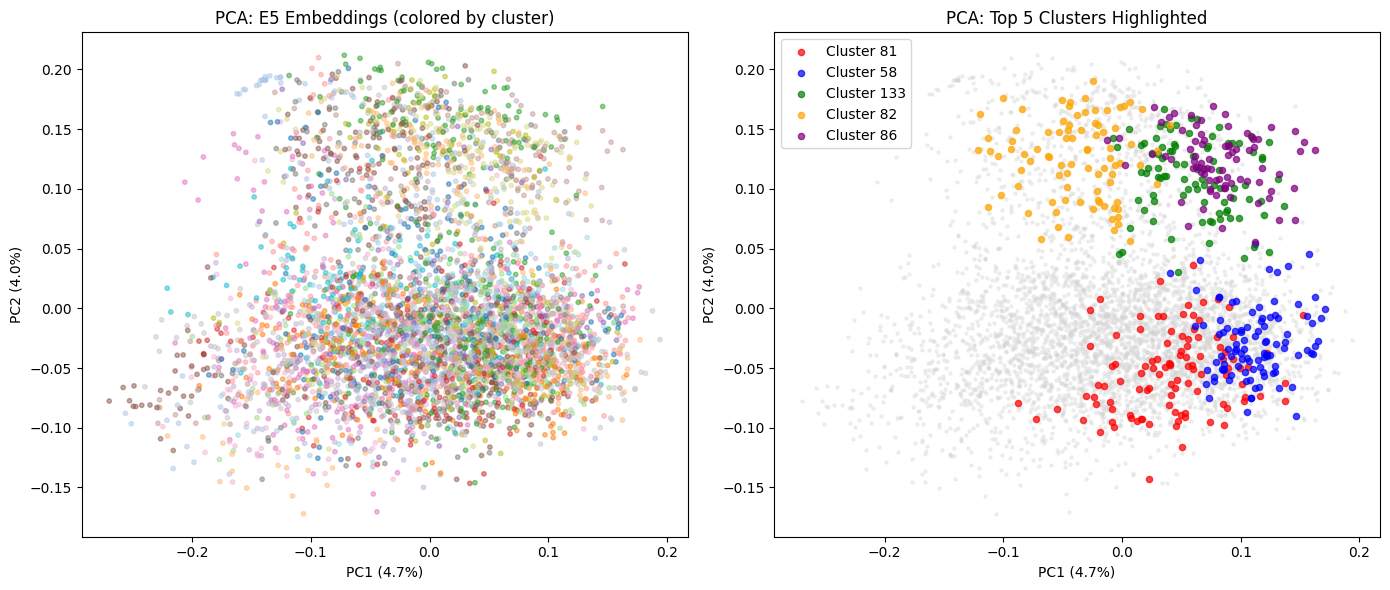

In [45]:
# Plot PCA results
plt.figure(figsize=(14, 6))

# Left: colored by cluster
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=viz_labels, 
    cmap='tab20',
    alpha=0.5,
    s=10
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA: E5 Embeddings (colored by cluster)')

# Right: highlight a few clusters
plt.subplot(1, 2, 2)
# Background points
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='lightgray', alpha=0.3, s=5)

# Highlight top 5 clusters
colors = ['red', 'blue', 'green', 'orange', 'purple']
top_clusters = pd.Series(viz_labels).value_counts().head(5).index.tolist()

for i, cluster_id in enumerate(top_clusters):
    mask = viz_labels == cluster_id
    plt.scatter(
        pca_result[mask, 0], 
        pca_result[mask, 1], 
        c=colors[i],
        alpha=0.7,
        s=20,
        label=f'Cluster {cluster_id}'
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA: Top 5 Clusters Highlighted')
plt.legend()

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs' / 'v8_pca_visualization.png', dpi=150)
plt.show()

In [46]:
# Try UMAP if available
try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("UMAP not installed. Install with: pip install umap-learn")
    HAS_UMAP = False

UMAP not installed. Install with: pip install umap-learn


In [47]:
if HAS_UMAP:
    print("Running UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine',
        random_state=42
    )
    umap_result = reducer.fit_transform(viz_embeddings)
    
    # Plot UMAP results
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(
        umap_result[:, 0], 
        umap_result[:, 1], 
        c=viz_labels, 
        cmap='tab20',
        alpha=0.5,
        s=10
    )
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP: E5 Embeddings (colored by cluster)')
    
    plt.subplot(1, 2, 2)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c='lightgray', alpha=0.3, s=5)
    
    for i, cluster_id in enumerate(top_clusters):
        mask = viz_labels == cluster_id
        plt.scatter(
            umap_result[mask, 0], 
            umap_result[mask, 1], 
            c=colors[i],
            alpha=0.7,
            s=20,
            label=f'Cluster {cluster_id}'
        )
    
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP: Top 5 Clusters Highlighted')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'outputs' / 'v8_umap_visualization.png', dpi=150)
    plt.show()
else:
    print("Skipping UMAP visualization (not installed)")

Skipping UMAP visualization (not installed)


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE (using smaller sample for speed)...


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

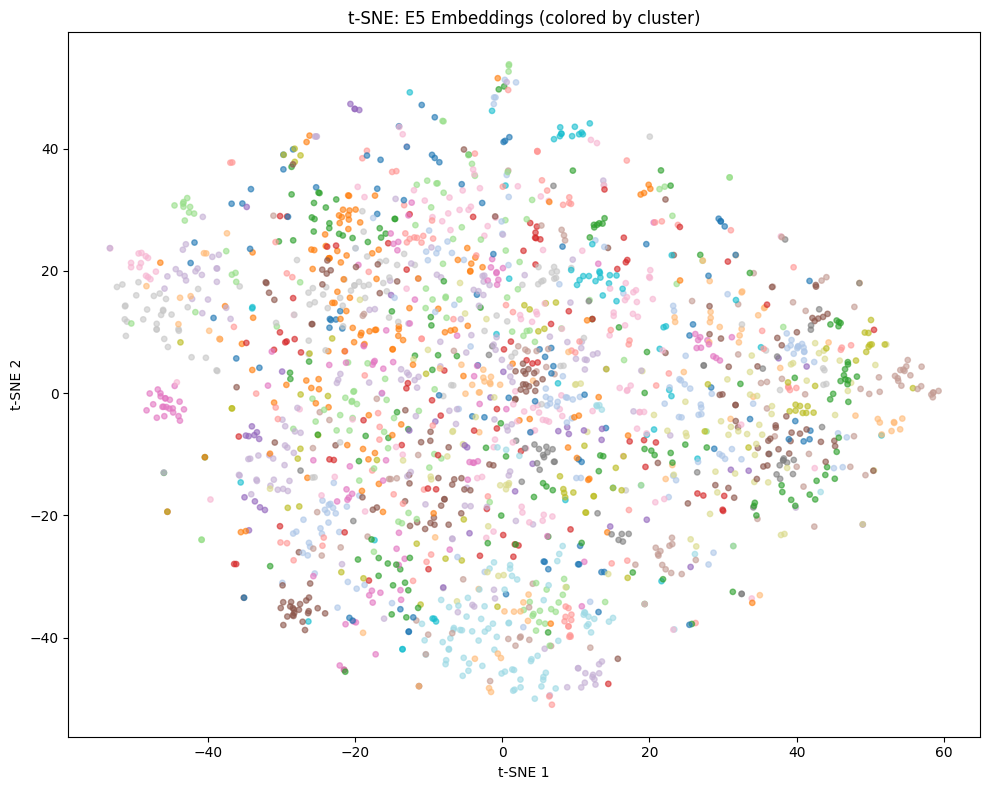

In [48]:
# t-SNE as alternative to UMAP
print("Running t-SNE (using smaller sample for speed)...")

n_tsne_samples = min(2000, len(viz_embeddings))
tsne_indices = np.random.choice(len(viz_embeddings), n_tsne_samples, replace=False)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    n_iter=1000
)
tsne_result = tsne.fit_transform(viz_embeddings[tsne_indices])
tsne_labels = viz_labels[tsne_indices]

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=tsne_labels, 
    cmap='tab20',
    alpha=0.6,
    s=15
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: E5 Embeddings (colored by cluster)')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs' / 'v8_tsne_visualization.png', dpi=150)
plt.show()

## 6. Prepare Training Dataset

In [49]:
# Create training dataset from synonym groups
def create_training_dataset(synonym_groups: dict) -> list:
    """
    Create training dataset where each entry has:
    - ko_term: Korean term
    - en_term: English translation
    - synonyms: list of related terms from same cluster
    """
    training_data = []
    
    for cluster_id, terms in synonym_groups.items():
        # Get all Korean and English terms in cluster
        ko_terms = [t['ko'] for t in terms]
        en_terms = [t['en'] for t in terms]
        
        for term in terms:
            # Other terms in same cluster are synonyms
            ko_synonyms = [t for t in ko_terms if t != term['ko']]
            en_synonyms = [t for t in en_terms if t != term['en']]
            
            training_data.append({
                'ko_term': term['ko'],
                'en_term': term['en'],
                'ko_synonyms': ko_synonyms[:5],  # Limit to 5 synonyms
                'en_synonyms': en_synonyms[:5],
                'cluster_id': int(cluster_id),
            })
    
    return training_data

training_data = create_training_dataset(synonym_groups)
print(f"Created {len(training_data)} training samples")

Created 10 training samples


In [50]:
# Preview training data
print("Sample training data:")
print("=" * 70)

for i in range(min(5, len(training_data))):
    sample = training_data[i]
    print(f"\n[{i}] {sample['ko_term']} → {sample['en_term']}")
    print(f"    KO synonyms: {sample['ko_synonyms'][:3]}")
    print(f"    EN synonyms: {sample['en_synonyms'][:3]}")
    print(f"    Cluster: {sample['cluster_id']}")

Sample training data:

[0] 무슨 소리야? → What the hell is that?
    KO synonyms: ['이게 뭔 소리래?', '무슨 소리죠?', 'What is that smell?']
    EN synonyms: ['What? What does that mean?', 'What does that mean?', "What's that knockin'?"]
    Cluster: 132

[1] 무슨 소리야? → What? What does that mean?
    KO synonyms: ['이게 뭔 소리래?', '무슨 소리죠?', 'What is that smell?']
    EN synonyms: ['What the hell is that?', 'What does that mean?', "What's that knockin'?"]
    Cluster: 132

[2] 무슨 소리야? → What does that mean?
    KO synonyms: ['이게 뭔 소리래?', '무슨 소리죠?', 'What is that smell?']
    EN synonyms: ['What the hell is that?', 'What? What does that mean?', "What's that knockin'?"]
    Cluster: 132

[3] 이게 뭔 소리래? → What's that knockin'?
    KO synonyms: ['무슨 소리야?', '무슨 소리야?', '무슨 소리야?']
    EN synonyms: ['What the hell is that?', 'What? What does that mean?', 'What does that mean?']
    Cluster: 132

[4] 무슨 소리죠? → What was that?
    KO synonyms: ['무슨 소리야?', '무슨 소리야?', '무슨 소리야?']
    EN synonyms: ['What the hell is that?

In [51]:
# Save training dataset
output_dir = PROJECT_ROOT / 'dataset' / 'v8_clustered'
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'synonym_clusters.jsonl'

with open(output_path, 'w', encoding='utf-8') as f:
    for item in training_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"Saved training dataset to: {output_path}")
print(f"Total samples: {len(training_data)}")

Saved training dataset to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl
Total samples: 10


In [52]:
# Save embeddings for later use
np.save(output_dir / 'ko_embeddings.npy', ko_embeddings)
np.save(output_dir / 'en_embeddings.npy', en_embeddings)
np.save(output_dir / 'cluster_labels.npy', cluster_labels)

print("Saved embeddings and cluster labels")

Saved embeddings and cluster labels


## 7. Summary Statistics

In [53]:
print("\n" + "=" * 70)
print("DATA PREPARATION SUMMARY")
print("=" * 70)
print(f"\nSource: OPUS-100 Korean-English parallel corpus")
print(f"Embedding model: {E5_MODEL_NAME}")
print(f"\nStatistics:")
print(f"  - Raw term pairs extracted: {len(raw_terms):,}")
print(f"  - Number of clusters: {n_clusters}")
print(f"  - Valid synonym groups: {len(synonym_groups)}")
print(f"  - Training samples: {len(training_data):,}")
print(f"\nOutput files:")
print(f"  - {output_path}")
print(f"  - {output_dir / 'ko_embeddings.npy'}")
print(f"  - {output_dir / 'en_embeddings.npy'}")
print(f"  - {output_dir / 'cluster_labels.npy'}")
print(f"\nVisualization saved to:")
print(f"  - outputs/v8_pca_visualization.png")
print(f"  - outputs/v8_tsne_visualization.png")


DATA PREPARATION SUMMARY

Source: OPUS-100 Korean-English parallel corpus
Embedding model: intfloat/multilingual-e5-large

Statistics:
  - Raw term pairs extracted: 47,441
  - Number of clusters: 154
  - Valid synonym groups: 3
  - Training samples: 10

Output files:
  - /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/synonym_clusters.jsonl
  - /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/ko_embeddings.npy
  - /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/en_embeddings.npy
  - /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v8_clustered/cluster_labels.npy

Visualization saved to:
  - outputs/v8_pca_visualization.png
  - outputs/v8_tsne_visualization.png


In [54]:
print("\nData preparation complete! Proceed to 02_training.ipynb for model training.")


Data preparation complete! Proceed to 02_training.ipynb for model training.
